<center><img src="img/Marca-ITBA-Color-ALTA.png" width="250">

<h1>Master en Management & Analytics</h1>
</center>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score

# Clustering Práctica - Preprocesamiento de datos

En esta práctica vamos a segmentar un dataset de consumidores de un e-commerce. El mismo cuenta con las columnas

* InvoiceNo: código identificatorio de la compra
* StockCode: código del producto
* Quantity: cantidad de unidades
* InvoiceDate: fecha de la compra
* UnitPrice: precio por unidad
* CustimerID: código identificatorio del cliente
* Country: país de la compra

Fuente: https://www.kaggle.com/carrie1/ecommerce-data

In [3]:
data = pd.read_csv('../Data/e_commerce.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## EDA

* Cómo está compuesta la columna country?


* Cuántas operaciones registra cada cliente?


* Filtrar el dataset conservando sól el país mayoritario

In [4]:
data['Country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

## Creación de variables

Vamos a trabajar con una representación de los consumidores basada en tres variables Recency, Frequency, Monetary value. A esta representación se la conoce como RFM. 

* Recency: mide cuán reciente es la última actividad registrada por un consumidor.
* Frequency: midel el número de compras en un intervalo de tiempo
* Monetary value: el monto total de las compras registradas

### Recency

1. Crear una columna llamada Date con la información contenida en InvoiceDate convertida a tipo datetime.

Ayuda: usar las siguentes lineas
```
data['Date'] = data['InvoiceDate'].apply(lambda x: x.split()[0].strip())
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y')
```

2. Generar un dataframe que contenga la última fecha de compra registrada para cada cliente. 

Ayuda: usar la función groupby('CustomerID')

3. En el dataframe creado en 2, generar una columna Recency con el número de días entre la última fecha de compra y el presente. Dado que el dataset es del 2011, tomar como el presente el último día registrado en el dataset.

Deberían obterer algo como

|CustomerID	| Recency |
| --- | --- | 
|	12346.0	| 325 |
|	12347.0	| 2 |
|	12348.0	| 75 |
|	12349.0	| 181 |
|	12350.0	| 310 |

In [57]:
data['Date'] = data['InvoiceDate'].apply(lambda x: x.split()[0].strip())
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y')
now = data['Date'].max() # ubicamos el presente como el último día registrado en el dataset
recency_df = data.groupby('CustomerID',as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurchase']
recency_df['Recency'] = recency_df['LastPurchase'].apply(lambda x: (now-x).days )
recency_df.drop(columns = 'LastPurchase', inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


### Frequency

Calcular el número de compras distintas (distinto InvoiceNo) hechas por cada cliente.

Generar un dataframe que contenga el CustomerID y la frecuencia.

In [10]:
temp = data.copy()
temp.drop_duplicates(['InvoiceNo','CustomerID'],keep='first',inplace=True)
frequency_df = temp.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [11]:
frequency_df.shape

(4372, 2)

### Monetary

Calcular el monto total gastado por cada cliente en toda su historia de compras.

Generar un dataframe que contenga el consumerID y el monto.


In [12]:
data['TotalQuantity'] = data['Quantity']*data['UnitPrice']
monetary_df = data.groupby('CustomerID',as_index=False).agg({'TotalQuantity':'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.shape

(4372, 2)

### Generar un dataframe RFM

Hacer un merge de los dataframes Recency, Frequency, Monetary alineado por la columna CustomerID.

In [13]:
rfm_table = recency_df.merge(frequency_df,on='CustomerID').merge(monetary_df,on='CustomerID')
rfm_table.set_index('CustomerID', inplace=True)
rfm_table.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


## Outliers

Hacer un análisis de outliers en las variables generadas. 

¿Considera necesario hacer un filtrado? ¿con qué criterio?

In [14]:
def get_cdf(series):
    x = series.sort_values().values
    y = np.ones(x.shape)
    y = np.cumsum(y) / len(x)
    return x, y

(0, 5000)

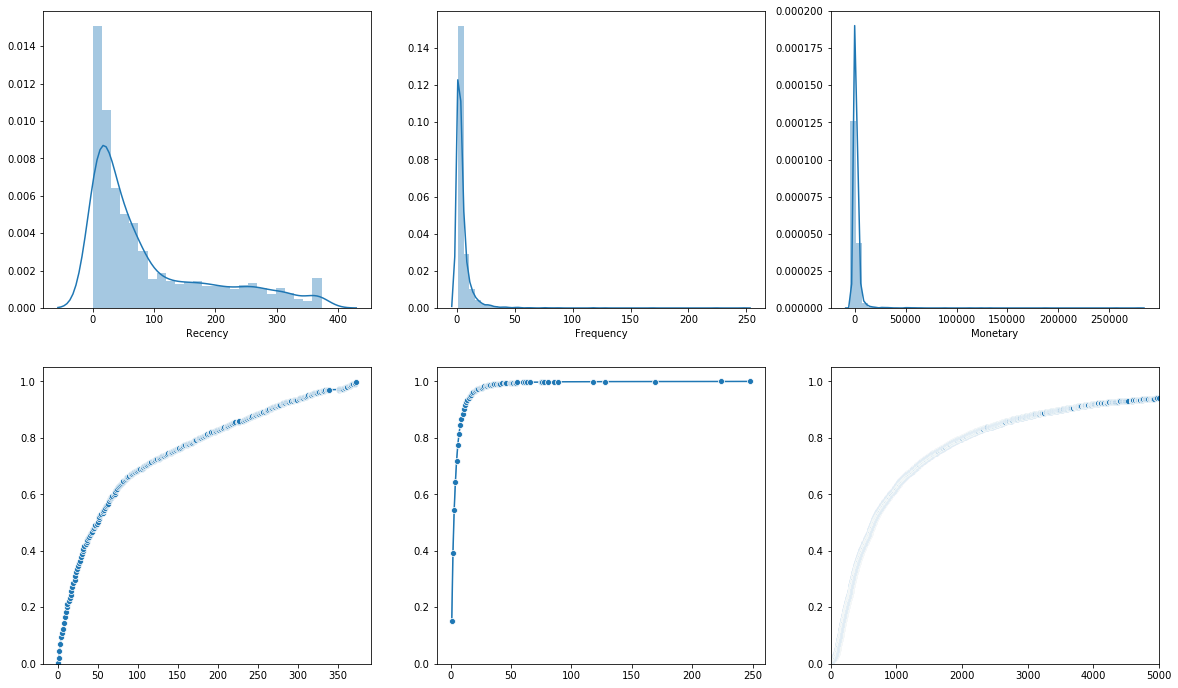

In [15]:
f, axes = plt.subplots(2,3,figsize=(20,12))

sns.distplot(rfm_table['Recency'], ax=axes[0,0])
sns.distplot(rfm_table['Frequency'], ax=axes[0,1])
sns.distplot(rfm_table['Monetary'], ax=axes[0,2])

values, cdf = get_cdf(rfm_table['Recency'])
sns.lineplot(values, cdf, marker = 'o', ax=axes[1,0])
values, cdf = get_cdf(rfm_table['Frequency'])
sns.lineplot(values, cdf, marker = 'o', ax=axes[1,1])
values, cdf = get_cdf(rfm_table['Monetary'])
sns.lineplot(values, cdf, marker = 'o', ax=axes[1,2])

for ax in axes[1,:]:
    ax.set_ylim([0, 1.05])
axes[1,2].set_xlim([0,5000])

In [16]:
outliers = (rfm_table['Frequency'] > 50) | (rfm_table['Monetary'] > 10000)
rfm_table = rfm_table.loc[~outliers]

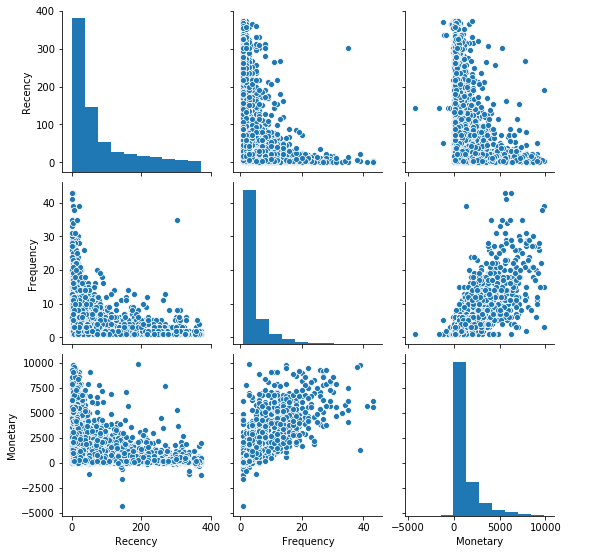

In [17]:
sns.pairplot(rfm_table)

### Estandarizacion

Estandaricen las tres variables RFM con la herramienta StandardScaler

### Kmeans

Implementen un modelo de Kmeans para distintos valores de k. 

Hagan un gráfico de la varianza del modelo (el atributo inertia_) y de los scores de silhouette y calinski-harabaz en función de k.

¿Qué valor de k eligirían?

Vuelvan a entrenar el modelo con ese valor de k y visualicen los resultados mediante un pairplot del dataset usando como hue las etiquetas de los clusters (como hicimos en la notebook de kmeans).

### Extra

Implementen un modelo de dbscan y uno jerárquico.

¿Cómo elegirían los hiperparámetros en cada caso?

¿Cómo varían los resultados respecto de kmeans?